<a href="https://colab.research.google.com/github/alirezaght/bitcoin-price-prediction/blob/main/train.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Download historical data

First we need to download the latest csv of historical data of bitcoin prices.

In [2]:
import pandas as pd
import requests
import json
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

def download_data():    
    url = f'https://www.cryptodatadownload.com/cdd/Bitstamp_BTCUSD_d.csv'
    data = pd.read_csv(url, skiprows=[0])  
    data['vol_fiat'] = data['Volume USD'] * data['close']  
    return data

data = download_data()
print(f"{len(data)} Rows downloaded")
print(data)

2481 Rows downloaded
            unix                 date  ...    Volume USD      vol_fiat
0     1631404800  2021-09-12 00:00:00  ...  1.844214e+05  8.338987e+09
1     1631318400  2021-09-11 00:00:00  ...  4.096648e+07  1.850729e+12
2     1631232000  2021-09-10 00:00:00  ...  1.073245e+08  4.814295e+12
3     1631145600  2021-09-09 00:00:00  ...  1.204351e+08  5.587324e+12
4     1631059200  2021-09-08 00:00:00  ...  1.525228e+08  7.030070e+12
...          ...                  ...  ...           ...           ...
2476  1417478400  2014-12-02 00:00:00  ...  6.832530e+03  2.591237e+06
2477  1417392000  2014-12-01 00:00:00  ...  6.660560e+03  2.520289e+06
2478  1417305600  2014-11-30 00:00:00  ...  3.046330e+03  1.137317e+06
2479  1417219200  2014-11-29 00:00:00  ...  7.245190e+03  2.729408e+06
2480  1417132800  2014-11-28 00:00:00  ...  8.617150e+03  3.242461e+06

[2481 rows x 10 columns]


# Create trainsets and testsets

We want to have a function to pick batch number from the dataset so the input will be like `# samples, # time steps, # features`

We are going to train our model with `Open price`, `High Price`, `Low Price` and `Close Price` as our features


In [16]:
from numpy import ndarray
import numpy as np
import random


def create_batch(batch_number: int, days_in_batch: int, predict_day: int, data_set: ndarray):      
  train_x = np.zeros((batch_number, days_in_batch, 4))
  train_y = np.zeros((batch_number, 1))  
  test_x = np.zeros((batch_number, days_in_batch, 4))  
  test_y = np.zeros((batch_number, 1))
  
  d = np.zeros((batch_number, days_in_batch + predict_day, 4))
  for i in range(batch_number):
    rand = random.randint(days_in_batch + predict_day, len(data_set) - 1)
    count = 0
    
    while count < days_in_batch:            
      d[i][count][0] = data_set["open"][rand]
      d[i][count][1] = data_set["high"][rand]
      d[i][count][2] = data_set["low"][rand]
      d[i][count][3] = data_set["close"][rand]
      
      
      count += 1
      rand -= 1
    for j in range(predict_day):
      d[i][-predict_day + j][0] = data_set["high"][rand - j]
      
    
  
  np.random.shuffle(d)

  train_size = int(0.8 * batch_number)

  train_x = d[0: train_size, 0:-predict_day]
  train_y = d[0: train_size, -predict_day:]
  test_x = d[train_size:, 0:-predict_day]
  test_y = d[train_size:, -predict_day:]  
  train_x = np.reshape(train_x, (train_x.shape[0],train_x.shape[1],4))
  test_x = np.reshape(test_x, (test_x.shape[0],test_x.shape[1],4))  
  train_y = train_y[:, :, 0:1]
  test_y = test_y[:, :, 0:1]
  return train_x, train_y, test_x, test_y

predict_day = 7
batch_number = len(data)
days_in_batch = 30

train_x, train_y, test_x, test_y = create_batch(batch_number, days_in_batch, predict_day, data)

# Train Model

In [26]:
from tensorflow.keras import layers
from tensorflow import keras
from tensorflow.keras.optimizers import RMSprop

class TrainingStop(keras.callbacks.Callback):
    def __init__(self, threshold):
        super(TrainingStop, self).__init__()
        self._threshold = threshold

    def on_epoch_end(self, batch, logs={}):         
        train_loss = logs.get('mape')
        self.model.stop_training = train_loss <= self._threshold

model = keras.Sequential()

model.add(layers.GRU(64, activation="relu", return_sequences=True))
model.add(layers.Dropout(0.2))
model.add(layers.GRU(64, activation="relu"))
model.add(layers.Dense(predict_day, activation="relu"))

model.compile(optimizer="rmsprop", loss="mae", metrics=["mape"])
# model.fit(train_x, train_y, epochs=100, callbacks=[TrainingStop(5)])
model.fit(train_x, train_y, epochs=20)
model.summary()

Epoch 1/20
62/62 [==============================] - 3s 24ms/step - loss: 8455.0000 - mape: 84.4507
Epoch 2/20
62/62 [==============================] - 1s 24ms/step - loss: 5713.7681 - mape: 56.4627
Epoch 3/20
62/62 [==============================] - 1s 24ms/step - loss: 4390.6431 - mape: 43.2070
Epoch 4/20
62/62 [==============================] - 1s 23ms/step - loss: 3739.7820 - mape: 36.9754
Epoch 5/20
62/62 [==============================] - 1s 24ms/step - loss: 3002.1179 - mape: 29.5016
Epoch 6/20
62/62 [==============================] - 1s 23ms/step - loss: 2772.7578 - mape: 26.7654
Epoch 7/20
62/62 [==============================] - 1s 23ms/step - loss: 2547.6487 - mape: 25.0556
Epoch 8/20
62/62 [==============================] - 1s 23ms/step - loss: 2543.3965 - mape: 24.8574
Epoch 9/20
62/62 [==============================] - 1s 23ms/step - loss: 2206.3503 - mape: 21.8226
Epoch 10/20
62/62 [==============================] - 1s 23ms/step - loss: 1593.1898 - mape: 15.1615
Epoch 11/

# Evaluate

16/16 [==============================] - 0s 8ms/step - loss: 908.9645 - mape: 9.1203
Mean Absolute Percentage Error: 9.120256423950195


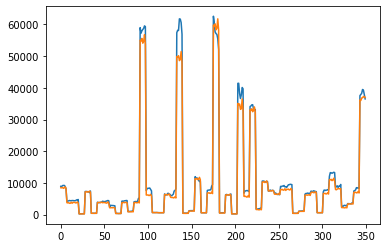

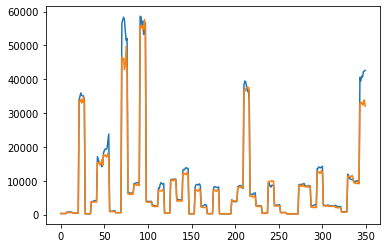

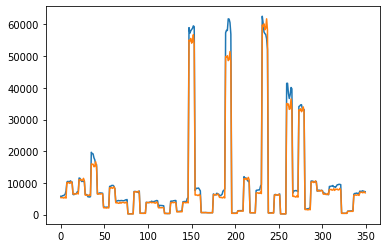

In [27]:
import matplotlib.pyplot as plt

def plot(sliced_data: ndarray):  
  p_data = np.reshape(sliced_data, (predict_day * len(sliced_data),))
  plt.plot(p_data)

size = 50
for i in range(3):
  plt.figure(i)
  rand = random.randint(0, len(test_y) - size - 1)
  plot(test_y[rand: rand + size])
  predicted = model.predict(test_x)
  plot(predicted[rand:rand + size])

loss, mape = model.evaluate(test_x, test_y)
print(f"Mean Absolute Percentage Error: {mape}")




# Save/Load

In [28]:
model.save("bitcoin-prediction-high.model")

# model = keras.models.load_model("bitcoin-prediction-high.model")

INFO:tensorflow:Assets written to: bitcoin-prediction-high.model/assets


# Predict nex week

Data downloaded.
Data received until 2021-09-13 00:00:00 - price 46027.8
Predicted for d + 1 => 44012.22265625 - 48026.25022037991
Predicted for d + 2 => 43611.45703125 - 47588.93374272086
Predicted for d + 3 => 44384.2890625 - 48432.250036947284
Predicted for d + 4 => 42881.47265625 - 46792.37292086609
Predicted for d + 5 => 43475.1796875 - 47440.22755577311
Predicted for d + 6 => 45531.84765625 - 49684.46891706236
Predicted for d + 7 => 42681.1171875 - 46573.744519606684


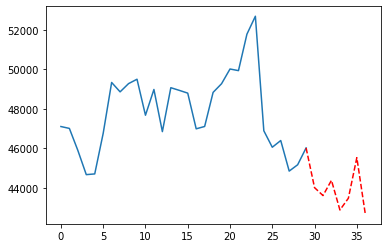

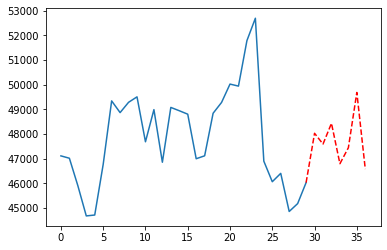

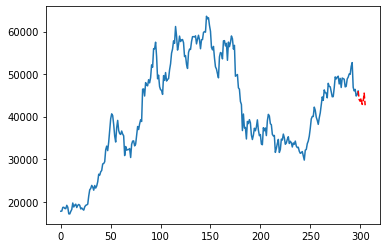

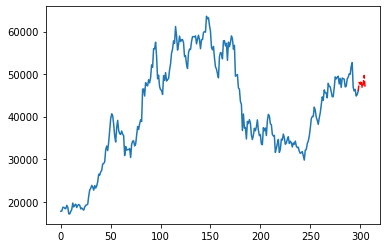

In [30]:
def fetch_daily_data(symbol):
    pair_split = symbol.split('/')  # symbol must be in format XXX/XXX ie. BTC/EUR
    symbol = pair_split[0] + '-' + pair_split[1]
    url = f'https://api.pro.coinbase.com/products/{symbol}/candles?granularity=86400'
    response = requests.get(url)
    if response.status_code == 200:  # check to make sure the response from server is good
        data = pd.DataFrame(json.loads(response.text), columns=['unix', 'low', 'high', 'open', 'close', 'volume'])
        data['date'] = pd.to_datetime(data['unix'], unit='s')  # convert to a readable date
        data['vol_fiat'] = data['volume'] * data['close']      # multiply the BTC volume by closing price to approximate fiat volume

        # if we failed to get any data, print an error...otherwise write the file
        if data is None:
            print("Did not return any data from Coinbase for this symbol")
        else:
            print("Data downloaded.")
            return data

    else:
        print("Did not receieve OK response from Coinbase API")

def last_n_days_data(data: ndarray, n: int):
  d = data[0:n]
  data_x = np.zeros((1, n, 4))
  count = 0
  index = n - 1
  while count < n:       
      data_x[0][count][0] = d["open"][index]
      data_x[0][count][1] = d["high"][index]
      data_x[0][count][2] = d["low"][index]
      data_x[0][count][3] = d["close"][index]
      
      count += 1
      index -= 1
  data_x = np.reshape(data_x, (data_x.shape[0], data_x.shape[1], 4))
  return data_x


downloaded_data = fetch_daily_data("BTC/USD")
new_data = last_n_days_data(downloaded_data, days_in_batch)


# prediction_days = 1
# predictions = np.zeros(prediction_days,)
# for i in range(prediction_days):
#   predicted_data = model.predict(new_data)   
#   _new = np.delete(new_data[0], 0)
#   _new = np.append(_new, predicted_data[0][0])        
#   _new = np.reshape(_new, new_data.shape)  
#   predictions[i] = predicted_data[0][0]
#   new_data = _new


predicted_data = model.predict(new_data)
predictions = predicted_data[0]

print(f"Data received until {downloaded_data['date'][0]} - price {downloaded_data['open'][0]}")
count = 0
for p_data in predictions:
  count += 1
  print(f"Predicted for d + {count} => {p_data} - {p_data * (1 + (mape/100.0))}")


first_half = np.array(downloaded_data['close'][days_in_batch:0:-1])
first_range = [*range(len(first_half))]
second_half = np.insert(predictions, 0, first_half[-1])
second_range = [*range(len(first_half) - 1, len(first_half) + len(second_half) - 1)]
plt.plot(first_range, first_half, second_range, second_half, 'r--')

plt.figure("res_multiply_by_mape")
predicted_data_multiply = predictions * (1 + (mape/100.0))
second_half = np.insert(predicted_data_multiply, 0, first_half[-1])
plt.plot(first_range, first_half, second_range, second_half, 'r--')

plt.figure("res_all")
first_half = np.array(downloaded_data['close'][:0:-1])
first_range = [*range(len(first_half))]
second_half = np.insert(predictions, 0, first_half[-1])
second_range = [*range(len(first_half) - 1, len(first_half) + len(second_half) - 1)]
plt.plot(first_range, first_half, second_range, second_half, 'r--')


plt.figure("res_multiply_by_mape_all")
predicted_data_multiply_all = predictions * (1 + (mape/100.0))
second_half = np.insert(predicted_data_multiply_all, 0, first_half[-1])
plt.plot(first_range, first_half, second_range, second_half, 'r--')

  